In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.backend import clear_session
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from tensorflow.image import ssim
import pandas as pd
from tensorflow.image import ssim
from tensorflow.math import reduce_mean
from custom_initializers_metrics import MixedGlorotNormal, MixedHeNormal, RMSE_SSIM
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.losses import MeanSquaredError

In [34]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

In [35]:
def load_image(image_path):
    with Image.open(image_path) as img:
        # Convert the image to a NumPy array
        img_array = np.array(img)

        # Optionally, normalize the image array if your model expects pixel values in [0, 1]
        img_array = img_array / 255.0

        return img_array

In [36]:
# Function to get all image paths from a directory
def get_image_paths(directory):
    # Get all file names in the directory
    all_files = os.listdir(directory)
    # Full paths of files
    return [os.path.join(directory, f) for f in all_files if f.endswith('.png')]


In [37]:
def combined_metric(y_true, y_pred):
    # Compute RMSE
    mse = MeanSquaredError()
    rmse = tf.sqrt(mse(y_true, y_pred))
    
    # Compute SSIM
    ssim_value = ssim(y_true, y_pred, max_val=1.0)  # Assuming y_true and y_pred are in [0, 1]
    
    # Compute the combined metric
    return (rmse + (1.0 - ssim_value)) / 2

In [38]:
# Retrieve all image paths
paths_94 = get_image_paths('2022_07_94_resize')
paths_171 = get_image_paths('2022_07_171_resize')
paths_193 = get_image_paths('2022_07_193_resize')
paths_211 = get_image_paths('2022_07_211_resize')

In [39]:
# Sort the paths to ensure they are aligned across the different angstrom measurements
paths_94.sort()
paths_171.sort()
paths_193.sort()
paths_211.sort()

In [40]:
# Ensure that you have the same number of images across all angstroms
assert len(paths_94) == len(paths_171) == len(paths_193) == len(paths_211), "Number of images in each angstrom directory must match"

# Stack the input images from different angstroms for each sample
input_images = np.array([np.stack((load_image(p94), load_image(p171), load_image(p193)), axis=-1) 
                         for p94, p171, p193 in zip(paths_94, paths_171, paths_193)])

# Load the output images
output_images = np.array([load_image(p211) for p211 in paths_211])

In [41]:
# Check the shapes
print('Input images shape:', input_images.shape)
print('Output images shape:', output_images.shape)

Input images shape: (100, 512, 512, 3)
Output images shape: (100, 512, 512)


In [42]:
# Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

In [27]:
# Contraction path
clear_session()
c1 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer= 'he_normal', padding='same')(s)
c1 = LeakyReLU()(c1)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(c1)
c1 = LeakyReLU()(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(p1)
c2 = LeakyReLU()(c2)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c2)
c2 = LeakyReLU()(c2)
p2 = MaxPooling2D((2, 2))(c2)


c3 = tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(p2)
c3 = LeakyReLU()(c3)
c3 = Dropout(0.1)(c3)
c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c3)
c3 = LeakyReLU()(c3)
p3 = MaxPooling2D((2, 2))(c3)


c4 = tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(p3)
c4 = LeakyReLU()(c4)
c4 = Dropout(0.1)(c4)
c4 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c4)
c4 = LeakyReLU()(c4)
p4 = MaxPooling2D((2, 2))(c4)


c5 = tf.keras.layers.Conv2D(521, (3, 3), kernel_initializer='he_normal', padding='same')(p4)
c5 = LeakyReLU()(c5)
c5 = Dropout(0.1)(c5)
c5 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(c5)
c5 = LeakyReLU()(c5)
p5 = MaxPooling2D((2, 2))(c5)


# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(u6)
c6 = LeakyReLU()(c6)
c6 = Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c6)
c6 = LeakyReLU()(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(u7)
c7 = LeakyReLU()(c7)
c7 = Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c7)
c7 = LeakyReLU()(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(u8)
c8 = LeakyReLU()(c8)
c8 = Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c8)
c8 = LeakyReLU()(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(u9)
c9 = LeakyReLU()(c9)
c9 = Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(c9)
c9 = LeakyReLU()(c9)

In [43]:
# Contraction path
clear_session()
c1 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer= 'glorot_uniform', padding='same')(s)
c1 = LeakyReLU()(c1)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), kernel_initializer='glorot_uniform', padding='same')(c1)
c1 = LeakyReLU()(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='glorot_uniform', padding='same')(p1)
c2 = LeakyReLU()(c2)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), kernel_initializer='glorot_uniform', padding='same')(c2)
c2 = LeakyReLU()(c2)
p2 = MaxPooling2D((2, 2))(c2)


c3 = tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='glorot_uniform', padding='same')(p2)
c3 = LeakyReLU()(c3)
c3 = Dropout(0.1)(c3)
c3 = Conv2D(64, (3, 3), kernel_initializer='glorot_uniform', padding='same')(c3)
c3 = LeakyReLU()(c3)
p3 = MaxPooling2D((2, 2))(c3)


c4 = tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer='glorot_uniform', padding='same')(p3)
c4 = LeakyReLU()(c4)
c4 = Dropout(0.1)(c4)
c4 = Conv2D(128, (3, 3), kernel_initializer='glorot_uniform', padding='same')(c4)
c4 = LeakyReLU()(c4)
p4 = MaxPooling2D((2, 2))(c4)


c5 = tf.keras.layers.Conv2D(521, (3, 3), kernel_initializer='glorot_uniform', padding='same')(p4)
c5 = LeakyReLU()(c5)
c5 = Dropout(0.1)(c5)
c5 = Conv2D(256, (3, 3), kernel_initializer='glorot_uniform', padding='same')(c5)
c5 = LeakyReLU()(c5)
p5 = MaxPooling2D((2, 2))(c5)


# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='glorot_uniform', padding='same')(u6)
c6 = LeakyReLU()(c6)
c6 = Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='glorot_uniform', padding='same')(c6)
c6 = LeakyReLU()(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='glorot_uniform', padding='same')(u7)
c7 = LeakyReLU()(c7)
c7 = Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='glorot_uniform', padding='same')(c7)
c7 = LeakyReLU()(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='glorot_uniform', padding='same')(u8)
c8 = LeakyReLU()(c8)
c8 = Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='glorot_uniform', padding='same')(c8)
c8 = LeakyReLU()(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer='glorot_uniform', padding='same')(u9)
c9 = LeakyReLU()(c9)
c9 = Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer='glorot_uniform', padding='same')(c9)
c9 = LeakyReLU()(c9)

In [44]:
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9) # try ReLU and others

In [45]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mean_squared_error']) 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mean_squared_error']) 
# model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=[combined_metric])
# model.summary()

In [46]:
X_train, X_test, y_train, y_test = train_test_split(input_images, output_images, test_size=0.1, random_state=42)

In [47]:
# This is an example. You'll need to set the actual number of epochs and batch size based on your dataset.
model.fit(X_train, y_train, validation_split=0.1, epochs=8, batch_size=8)
model.evaluate(X_test, y_test)
model.save('model.h5')
predictions = model.predict(X_test)

Epoch 1/8
11/11 [==============================] - 171s 15s/step - loss: 0.6178 - mean_squared_error: 0.0934 - val_loss: 0.5647 - val_mean_squared_error: 0.0728
Epoch 2/8
11/11 [==============================] - 279s 26s/step - loss: 0.5129 - mean_squared_error: 0.0488 - val_loss: 0.4691 - val_mean_squared_error: 0.0323
Epoch 3/8
11/11 [==============================] - 321s 29s/step - loss: 0.4700 - mean_squared_error: 0.0323 - val_loss: 0.4691 - val_mean_squared_error: 0.0322
Epoch 4/8
11/11 [==============================] - 320s 29s/step - loss: 0.4655 - mean_squared_error: 0.0312 - val_loss: 0.4628 - val_mean_squared_error: 0.0303
Epoch 5/8
11/11 [==============================] - 321s 29s/step - loss: 0.4593 - mean_squared_error: 0.0292 - val_loss: 0.4576 - val_mean_squared_error: 0.0292
Epoch 6/8
11/11 [==============================] - 320s 29s/step - loss: 0.4587 - mean_squared_error: 0.0286 - val_loss: 0.4508 - val_mean_squared_error: 0.0272
Epoch 7/8
11/11 [=================

In [ ]:
'''
# Assuming predictions might have an extra singleton dimension, remove it if present
if predictions.ndim == 4 and predictions.shape[-1] == 1:
    predictions = np.squeeze(predictions, axis=-1)

# Ensure the true output is correctly formatted for visualization
if y_test.ndim == 4 and y_test.shape[-1] == 1:
    y_test_visual = np.squeeze(y_test[0], axis=-1)
else:
    y_test_visual = y_test[0]

plt.figure(figsize=(12, 4))

# Input (94 Å)
plt.subplot(1, 3, 1)
plt.imshow(X_test[0, :, :, 0], cmap='gray')  # Assuming the first channel corresponds to 94 Å
plt.title('Input: 94 Å')

# True Output (211 Å)
plt.subplot(1, 3, 2)
plt.imshow(y_test_visual, cmap='gray')  # Visualize the first sample's true output
plt.title('True Output: 211 Å')

# Predicted Output (211 Å)
plt.subplot(1, 3, 3)
plt.imshow(predictions[0], cmap='gray')  # Visualize the first sample's predicted output
plt.title('Predicted Output: 211 Å')

plt.savefig('outputs/segmentation_results.png')

plt.show()
'''

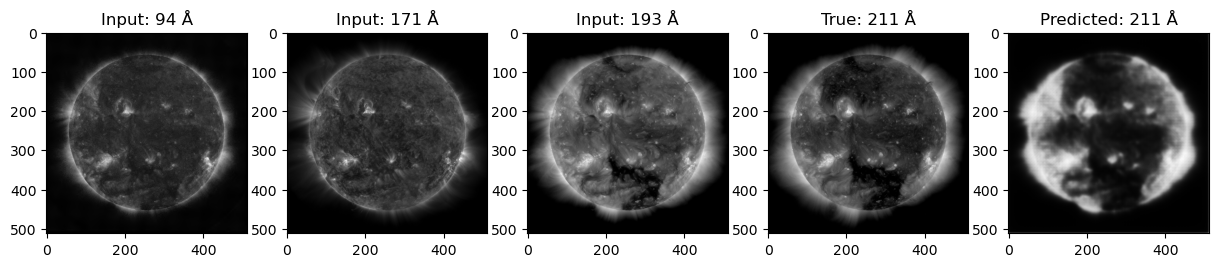

In [48]:
# Assuming predictions might have an extra singleton dimension, remove it if present
if predictions.ndim == 4 and predictions.shape[-1] == 1:
    predictions = np.squeeze(predictions, axis=-1)

# Ensure the true output is correctly formatted for visualization
if y_test.ndim == 4 and y_test.shape[-1] == 1:
    y_test_visual = np.squeeze(y_test[0], axis=-1)
else:
    y_test_visual = y_test[0]
    
# Adjust the figsize and layout to accommodate 5 images
plt.figure(figsize=(15, 3))

# Input (94 Å)
plt.subplot(1, 5, 1)
plt.imshow(X_test[0, :, :, 0], cmap='gray')  # First channel (94 Å)
plt.title('Input: 94 Å')

# Input (171 Å)
plt.subplot(1, 5, 2)
plt.imshow(X_test[0, :, :, 1], cmap='gray')  # Second channel (171 Å)
plt.title('Input: 171 Å')

# Input (193 Å)
plt.subplot(1, 5, 3)
plt.imshow(X_test[0, :, :, 2], cmap='gray')  # Third channel (193 Å)
plt.title('Input: 193 Å')

# True Output (211 Å)
plt.subplot(1, 5, 4)
plt.imshow(y_test_visual, cmap='gray')  # True output for 211 Å
plt.title('True: 211 Å')

# Predicted Output (211 Å)
plt.subplot(1, 5, 5)
plt.imshow(predictions[0], cmap='gray')  # Predicted output for 211 Å
plt.title('Predicted: 211 Å')

# Save the figure to a file
plt.savefig('outputs/segmentation_results_4.png')

# Display the figure
plt.show()
